# Simulated grouped Normal regression

We'll repeatedly fit a grouped Normal regression to simulated data to test MCMC convergence statistics on repeated inferences.

$$y_{ij} \sim \mathcal{N}(\alpha_j+x_{j[i]}^\top\beta, \sigma_y^2)$$
$$\alpha_j \sim N(\mu_\alpha, \sigma^2_\alpha)$$
$$\sigma_\alpha \sim N^+(0,10)$$
$$\sigma_y \sim N^+(0,10)$$
$$\beta_k \sim N(0,1)$$
$$\mu_\alpha \sim N(0,1)$$

This is the example we'll use throughout the main text, and follow up with actual data at the end of the paper.

In [ ]:
#@title Simulation parameters

#@markdown ## Computation
#@markdown Computation device and numerical precision
arithmetic = "fp64"  #@param ["fp64", "fp32"]
if arithmetic == "fp64":
    from jax.config import config
    config.update("jax_enable_x64", True)
backend = "gpu"  #@param ["gpu", "cpu"]

import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

dtype = jnp.float64 if arithmetic == "fp64" else jnp.float32

#@markdown ## Parameters
#@markdown Number of groups
J = 50  #@param
#@markdown For simplicity, each group has the same number of observations, $N_j$
N_j = 5  #@param
#@markdown Number of covariates
p = 4  #@param
#@markdown Covariates distribution
X_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros((J, p)), scale_diag=10*jnp.ones((J, p)))  #@param
group_i = jnp.repeat(jnp.arange(J), N_j)
#@markdown Random seed for simulations and inference
seed = 123  #@param
key = jax.random.PRNGKey(seed)


## Set up

In [ ]:
#@title Install dependencies

%pip install -q --upgrade pip
# freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
#@title Inference procedures: separate parameter classes

import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState
import zipfile
import json
import jax
import jax.numpy as jnp
import arviz as az
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
import welford as wf
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import ticker
from tqdm.notebook import tqdm
import pickle
import time
import seaborn as sns
tfd = tfp.distributions
tfb = tfp.bijectors

from typing import NamedTuple
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import seaborn as sns

import jax
import jax.numpy as jnp
from jax.scipy import stats
from tensorflow_probability.substrates import jax as tfp

# Extended MCMC state
class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: wf.LogWelfordState  # accumulator for log predictive
    pred_bws: wf.BatchLogWelfordState  # batch accumulator for log predictive, size b
    divergences: jax.Array  # divergence counts (int array)

# Approximate MAP
@partial(jax.jit, static_argnames=['mip', 'ljd'])
def find_initial_params(rng_key, mip, ljd, adam_iter, adam_lr):
    """Use adam to approximately maximize the log joint density.

    Args:
        rng_key: random state
        mip: function to make initial position, which takes a key and should be a random prior draw
        ljd: log joint density function
        adam_iter: iterations
        adam_lr: learning rate
    """
    import optax
    params = mip(rng_key)
    optimizer = optax.adam(learning_rate=adam_lr)
    f = lambda x: -ljd(x)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, _ = jax.lax.fori_loop(0, adam_iter, loop_body, (params, state))
    return params

class Model(NamedTuple):
    logjoint_density: Callable
    log_pred: Callable
    make_initial_pos: Callable
    to_constrained: Callable
    priors: Dict[str, tfd.Distribution]
    Theta: object


class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    divergences: jax.Array  # divergence counts (int array)


class MCMCResults(NamedTuple):
    model: Model
    fold_id: int
    trace: object  # model.Theta
    adapt_res: bj.kernels.AdaptationResults

    def arviz(self):
        """Turn trace into an Arviz object
        """
        # compute predictive draws: dims (draw, chain)
        lp_draws = jax.vmap(jax.vmap(lambda x: self.model.log_pred(x, self.fold_id)))(self.trace)  # use unconstrained variables
        # transform back to constrained parameter space
        constrained_trace = jax.vmap(self.model.to_constrained)(self.trace)
        _params = {v : constrained_trace[i] for i, v in enumerate(self.trace._fields)}
        _params['log_pred'] = lp_draws
        _params['scaled_pred'] = jnp.exp(lp_draws - jnp.max(lp_draws))
        return az.convert_to_inference_data(_params)


def full_trace_inference(
    model: Model,
    fold_id,
    inference_key,
    num_integration_steps,
    num_chains,
    iter,
    warmup_iter,
    adapt_iter,
    adam_iter,
    adam_lr,
    backend='gpu'):
    """Single-model, single fold MCMC inference
    """

    def init_ext_state(state, rng_key):
        """Create initial state"""
        return ExtendedState(
            state=state,
            rng_key=rng_key,
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def reset_ext_state(state):
        """Reset averages after warmup"""
        return ExtendedState(
            state=state.state,
            rng_key=state.rng_key,
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    @partial(jax.jit, static_argnames=['num_samples'], backend=backend)
    def single_inference_loop(ext_states, fold_id, num_samples) -> Tuple[ExtendedState, HMCState]:
        hmc = bj.hmc(lambda x: model.logjoint_density(x, fold_id), **adapt_res.parameters)
        def one_chain_inference_loop(state):  # Single chain inference loop
            def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
                # Single chain, single MCMC step.
                iter_key, carry_key = jax.random.split(ext_state.rng_key)
                chain_state, chain_info = hmc.step(iter_key, ext_state.state)
                #elpd_contrib = model.log_pred(chain_state.position, fold_id)
                carry_state = ExtendedState(
                    state=chain_state,
                    rng_key=carry_key,
                    divergences=ext_state.divergences + chain_info.is_divergent,
                )
                return carry_state, chain_state.position
            next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
            return next_state, trace
        # run all chains for this fold in parallel
        return jax.vmap(one_chain_inference_loop)(ext_states)

    start_at = time.time()

    state_k, sampling_k, adapt_k = jax.random.split(inference_key, 3)
    # parameter adaptation
    fd_ljd = lambda x: model.logjoint_density(x, fold_id)
    init_pos_1c = find_initial_params(state_k, model.make_initial_pos, fd_ljd, adam_iter, adam_lr)
    adapt = bj.window_adaptation(
        bj.hmc,
        fd_ljd,
        num_integration_steps=num_integration_steps,
        progress_bar=True)
    adapt_res, _ = adapt.run(adapt_k, init_pos_1c, num_steps=adapt_iter)
    print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
    print()

    fm_hmc = bj.hmc(lambda x: model.logjoint_density(x, fold_id), **adapt_res.parameters)
    state_ks = jax.random.split(state_k, num_chains)
    ljd = lambda x: model.logjoint_density(x, fold_id)
    init_pos = lambda k: find_initial_params(k, model.make_initial_pos, ljd, adam_iter, adam_lr)
    fm_init_pos = jax.vmap(init_pos)(state_ks)
    fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
    initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

    # final warm-up step
    print("Warm-up sampling run")
    state, _ = single_inference_loop(initstate, fold_id, warmup_iter)
    state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in
    print(f"Warmup complete in {time.time() - start_at:.2f} sec")

    print("Sampling")
    start_at = time.time()
    state, trace = single_inference_loop(state, fold_id, iter)
    state.divergences.block_until_ready()
    if state.divergences.sum() > 0:
        print(f"{state.divergences.sum()} divergences seen during inference")
    print(f"Done in {time.time() - start_at:.2f} sec")

    return MCMCResults(model, fold_id, trace, adapt_res)


#This version retains only predictive draws. MCMC draws are dropped.
#JIT-compiled for GPU.

def logvar(lxs, ddof=0, axis=None):
    # compute log(var(m*exp(x))/m^2) = log(var(exp(x)))
    m = jnp.max(lxs)
    return jnp.log(jnp.var(jnp.exp(lxs - m), ddof=ddof, axis=axis)) + 2*m

def parallel_cv(
    resultsA: MCMCResults,
    resultsB: MCMCResults,
    inference_key: jax.random.KeyArray,
    num_folds,
    iter,
    batch_size,
    num_chains,
    warmup_iter,
    d,
    backend='gpu'
):
    def init_ext_state(state, rng_key):
        """Create initial state"""
        return ExtendedState(
            state=state,
            rng_key=rng_key,
            # pred_ws=wf.log_welford_init(()),
            # pred_bws=wf.batch_log_welford_init((), batch_size),
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def reset_ext_state(state):
        """Reset averages after warmup"""
        return ExtendedState(
            state=state.state,
            rng_key=state.rng_key,
            # pred_ws=wf.log_welford_init(()),
            # pred_bws=wf.batch_log_welford_init((), batch_size),
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def init_one_fold(key: jax.random.KeyArray, fold_id: jax.Array) -> Tuple[ExtendedState, ExtendedState]:
        def init_1mf(res, mkey):
            m = res.model
            params = res.adapt_res.parameters
            trace = res.trace
            state_k, sampling_k = jax.random.split(mkey)
            ljd = lambda x: m.logjoint_density(x, fold_id)
            fm_hmc = bj.hmc(ljd, **params)
            # sample initial positions from full-data trace
            def find_initial_params(key):
                nchains, ndraws = trace[0].shape[:2]
                chain_i = jax.random.randint(key, shape=(), minval=0, maxval=nchains)
                draw_i = jax.random.randint(key, shape=(), minval=0, maxval=ndraws)
                return jax.tree_map(lambda x: x[chain_i,draw_i,...], trace)
            state_ks = jax.random.split(state_k, num_chains)
            fm_init_pos = jax.vmap(find_initial_params)(state_ks)
            fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
            chain_ks = jax.random.split(sampling_k, num_chains)
            return jax.vmap(init_ext_state)(fm_init_hmcstates, chain_ks)
        keyA, keyB = jax.random.split(key)
        return init_1mf(resultsA, keyA), init_1mf(resultsB, keyB)

    def inference_loop(
            ext_state: ExtendedState,
            fold_id: jax.Array,
            model_id: int, # static argument
            iter: int # static argument
            ) -> Tuple[ExtendedState, HMCState]:
        # since model_id is static, jax will execute and compile results of if statements
        model = resultsA.model if model_id == 0 else resultsB.model
        adapt_p = resultsA.adapt_res.parameters if model_id == 0 else resultsB.adapt_res.parameters
        hmc_kernel = bj.hmc(lambda pos: model.logjoint_density(pos, fold_id), **adapt_p)
        def one_chain_inference_loop(state):  # inference loop for single chain per model
            def one_mcmc_step(ext_state: ExtendedState, _idx) -> Tuple[ExtendedState, HMCState]:
                # Single MCMC step
                iter_key, carry_key = jax.random.split(ext_state.rng_key)
                chain_state, chain_info = hmc_kernel.step(iter_key, ext_state.state)
                elpd_contrib = model.log_pred(chain_state.position, fold_id)
                carry_state = ExtendedState(
                    state=chain_state,
                    rng_key=carry_key,
                    # pred_ws=wf.log_welford_add(elpd_contrib, ext_state.pred_ws),
                    # pred_bws=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                    divergences=ext_state.divergences + chain_info.is_divergent,
                )
                return carry_state, elpd_contrib
            return jax.lax.scan(one_mcmc_step, state, jnp.arange(iter))
        # run all chains for this fold in parallel
        return jax.vmap(one_chain_inference_loop)(ext_state)

    # each has dimensions folds x chains x param dimension
    fold_ids = jnp.arange(num_folds)
    sampling_ks = jax.random.split(inference_key, num_folds)
    init_stateA, init_stateB = jax.vmap(init_one_fold)(sampling_ks, fold_ids)

    @partial(jax.jit, static_argnames=['iterations', 'model_id'], backend=backend)
    def grand_inference_loop(state: ExtendedState, model_id: int, iterations: int):
        def fold_inference_loop(state: ExtendedState, fold_id: jax.Array):
            return inference_loop(state, fold_id, model_id, iterations)
        return jax.vmap(fold_inference_loop)(state, fold_ids)

    # final warmup step: run chains to get to stationarity
    stateA, stateB = init_stateA, init_stateB
    print(f"Warmup run")
    start_at = time.time()
    stateA, _ = grand_inference_loop(stateA, 0, warmup_iter)
    stateB, _ = grand_inference_loop(stateB, 1, warmup_iter)
    stateA = jax.vmap(jax.vmap(reset_ext_state))(stateA)
    stateB = jax.vmap(jax.vmap(reset_ext_state))(stateB)
    stateA.divergences.block_until_ready()
    stateB.divergences.block_until_ready()
    print(f"Warmup complete in {time.time() - start_at:.1f} sec")

    print(f"Inference")
    start_at = time.time()
    stateA, traceA = grand_inference_loop(stateA, 0, iter)
    stateB, traceB = grand_inference_loop(stateB, 1, iter)
    stateA.divergences.block_until_ready()
    stateB.divergences.block_until_ready()
    print(f"Inference complete in {time.time() - start_at:.1f} sec")
    for state, model_name in [(stateA, 'A'), (stateB, 'B')]:
        if state.divergences.sum() > 0:
            print(f"Model {model_name} saw {state.divergences.sum()} divergences")
            chains = '\n\t'.join([
                f'  {model_name}, fold {k}, chain {c}: {state.divergences[k,c].sum()}'
                for k in range(num_folds)
                for c in jnp.where(state.divergences[k,:] != 0)
                if state.divergences[k,:].sum() > 0])
            print(chains)

    trace = jnp.stack([traceA, traceB], axis=3)
    fm_elpds = logsumexp(trace, axis=(1,2)) - jnp.log(iter * num_chains)
    f_elpd_diff = fm_elpds[:,0] - fm_elpds[:,1]
    elpd_diff = f_elpd_diff.sum()

    print(f"Done")

    res = dict(
        elpd_diff = elpd_diff,
        mf_elpds = fm_elpds,
        f_elpd_diff = f_elpd_diff,
        trace = trace,
        num_folds = num_folds,
        iter = iter,
        batch_size = batch_size,
        num_chains = num_chains,
        d = d,
        warmup_iter = warmup_iter,
        inference_key = inference_key,
    )
    # get the results of the gpu into numpy arrays
    res = {k: np.array(res[k]) if isinstance(res['trace'], jnp.ndarray) else res[k]
           for k in res}
    return res

In [ ]:
#@title Full-trace and foldwise plot functions

def unframe_axes(axes):
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

def plot_batch_sizes(idata, min=10, max=200, step=10):
    fig, ax = plt.subplots(1, 1, figsize=(10,3.5), sharey=True)
    lp_draws = np.array(idata.posterior['log_pred'])
    num_chains, num_iter = lp_draws.shape
    bs = np.arange(min, max, step)

    def logvar(lxs, ddof=0, axis=None):
        # compute log(var(m*exp(x))/m^2) = log(var(exp(x)))
        m = lxs.max()
        return np.log(np.var(np.exp(lxs - m), ddof=ddof, axis=axis)) + 2*m

    def ess(b):
        ab = (num_iter // b) * b
        a = ab // b
        llambdasq = logvar(lp_draws[:ab], ddof=1) - np.log(ab)
        batches = lp_draws[:,:ab].reshape((num_chains, a, b))
        lmean = logsumexp(lp_draws) - np.log(ab*num_chains)
        batch_means = logsumexp(batches, axis=2) - np.log(b)
        lsigsq = logvar(batch_means, ddof=1) + np.log(b) - np.log(ab)
        lsigsq_S = lsigsq - 2*lmean
        llambdasq_S = llambdasq - 2*lmean
        less = np.log(ab) + np.log(num_chains) + llambdasq_S - lsigsq_S
        return np.exp(less)

    ax.scatter(bs, np.array([ess(b) for b in bs]), marker='.', label='Batch means')
    ax.axhline(az.ess(idata, var_names='scaled_pred', method='mean')['scaled_pred'],
               color='darkgreen', label='Window method')
    ax.legend()
    ax.set_title(f"Computed for estimated score")
    ax.set_ylabel('ESS')
    ax.set_xlabel('Batch size')

    fig.suptitle(f'ESS for {num_iter*num_chains} raw MCMC draws')
    fig.tight_layout()
    return fig, ax

def gini(x):
    z = x - jnp.min(x)
    lorenz = jnp.cumsum(jnp.sort(z)) / jnp.sum(z)
    return 1 - 2*jnp.trapz(lorenz, dx=1./len(x))

def est_var(trace, b = 50):
    """Estimate variance sigma^2 and lambda^2 from draws

    Param:
        trace: phat draws with dimensions (folds, chains, iterations, models)
        b: batch size
    """
    K, L, N, M = trace.shape
    ab = (N // b) * b  # useful length
    a = ab // b  # num batches per chain
    abc = ab * L  # total number of samples
    # raw scaled variance for mean (includes /cab)
    fm_llambdasq = logvar(trace, axis=(1,2), ddof=1)
    # scaled MC variance for mean (ie includes /cab)
    fcabm_batches = trace[:, :, :ab, :].reshape(K, L, a, b, M)
    fcam_batch_means = logsumexp(fcabm_batches, axis=3) - jnp.log(b)
    fm_lsigsq = logvar(fcam_batch_means, axis=(1,2), ddof=1) + jnp.log(b)
    # estimated log mean
    fm_lmean = logsumexp(fcam_batch_means, axis=(1,2)) - jnp.log(a) - jnp.log(L)
    # estimate variance for log score
    fm_lMCmeanvar_S = (fm_lsigsq - jnp.log(abc)) - 2*fm_lmean
    fm_lrawvar_S = (fm_llambdasq - jnp.log(abc)) - 2*fm_lmean
    lMCvar_S = logsumexp(fm_lMCmeanvar_S)
    lrawvar_S = logsumexp(fm_lrawvar_S)
    # effective sample size - fold and overall
    # note here it doesn't matter if we apply the delta method, BUT
    fm_ess = jnp.exp(jnp.log(abc) + fm_llambdasq - fm_lsigsq)
    # under independence of folds, we can add variances
    # but this REQUIRES the delta method to be applied first
    ess = jnp.exp(jnp.log(abc) + lrawvar_S - lMCvar_S)
    # delta estimated using all draws, including left-out batch remainder
    fm_lmean_all = logsumexp(trace, axis=(1,2)) - jnp.log(N) - jnp.log(L)
    lmean_all = (fm_lmean_all[:,0] - fm_lmean_all[:,1]).sum()
    return dict(
        fm_lsigmasq=fm_lsigsq,
        fm_llambdasq=fm_llambdasq,
        lMCvar_S = lMCvar_S,
        lrawvar_S = lrawvar_S,
        fm_ess = fm_ess,
        ess = ess,
        lmean = lmean_all,
        fm_lmean = fm_lmean_all,
        K = K,
        L = L,
        N = N,
        M = M,
    )

def rhat_eta(trace):
    """Compute rhat for log score difference

    Param:
        trace: phat draws with dimensions (folds, chains, iterations, models)
    """
    K, L, N, _ = trace.shape
    fcm_lmean = logsumexp(trace, axis=2) - jnp.log(N)
    c_etahat = (fcm_lmean[:,:,0] - fcm_lmean[:,:,1]).sum(axis=0)

    fcm_llambdasq = logvar(trace, ddof=1, axis=2)
    fcm_lvar_phat = fcm_llambdasq - np.log(N)
    fcm_lvar_fold = fcm_lvar_phat - 2*fcm_lmean
    c_lvareta = logsumexp(fcm_lvar_fold, axis=(0,2))  # add variances of independent chains
    lW = logsumexp(c_lvareta) - np.log(L)
    lB = np.log(np.var(c_etahat, ddof=1)) #+ np.log(N)  # <-- do we want N term?

    lrhat_eta = np.logaddexp(lW + np.log(N-1) - np.log(N), lB - np.log(N)) - lW
    return np.exp(lrhat_eta)

def shuffle_draws(trace, breaks=10, iter_ax=2, chain_ax=1):
    start_at = 0
    spans = np.split(trace, breaks, axis=iter_ax)
    for i in range(len(spans)):
        span = spans[i]
        nchains, span_len = span.shape[chain_ax], span.shape[iter_ax]
        idxs = np.random.choice(np.arange(nchains), nchains, replace=True)
        spans[i] = span[:, idxs, :, :]
        start_at += span_len
    return np.concatenate(spans, axis=iter_ax)

def shuffle_rhats(trace, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return rhats

def max_shuffle_rhat(trace, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return rhats.max()

def q_shuffle_rhat(trace, q=0.99, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return np.quantile(rhats, q=q)

def est_probs(vars, d = 0.05, ndraws = 500, key = jax.random.PRNGKey(123)):
    K, L, N, M = vars['K'], vars['L'], vars['N'], vars['M']
    epsilon = jax.random.truncated_normal(key, lower=0, upper=jnp.inf, shape=(K, M, ndraws,))
    lmean = jnp.expand_dims(vars['fm_lmean'], axis=2)
    lsigma = 0.5 * (jnp.expand_dims(vars['fm_lsigmasq'], axis=2) - jnp.log(N))  # log sigma/sqrt(N)
    lp_draws = jnp.logaddexp(lmean, lsigma + jnp.log(epsilon))  # p ~ TN(mean, sigma^2/N; 0, inf)
    deltahat_draws = lp_draws[:,0,:] - lp_draws[:,1,:]
    deltahat_mu = deltahat_draws.sum(axis=0)  # sum over folds
    deltahat_sigsq = K*jnp.var(deltahat_draws, axis=0, ddof=1)
    from jax.scipy.stats import norm
    cv_probs = 1. - norm.cdf(0., loc=deltahat_mu, scale=deltahat_sigsq)  # right tail area
    return dict(
        cv_prob = cv_probs.mean(),
        cv_qs = np.quantile(cv_probs, q=[d/2, 1 - d/2]),
        # cv_probs = cv_probs,
        delta_prob = (deltahat_mu > 0).mean(),
        # deltahat_mu = deltahat_mu,
        deltahat_sigsq = deltahat_sigsq.mean(),
    )

def rhat(trace, draw_axis=2, chain_axis=1):
    assert draw_axis > chain_axis
    n = trace.shape[draw_axis]
    W = np.mean(np.var(trace, axis=draw_axis, ddof=1), axis=chain_axis)
    B = n*np.var(np.mean(trace, axis=draw_axis), ddof=1, axis=chain_axis)
    V = (n-1)*W/n + B/n
    return np.sqrt(V/W)

def fold_rhat(trace, title=r'Fold $\widehat{R}$'):
    K, L, N, M = trace.shape
    sublengths = np.arange(0, N+1, step=N//50)[1:]
    rhats = np.array([rhat(trace[:,:,:l,:]) for l in sublengths])
    #eta_rhat = np.array([rhat_eta(trace[:,:,:l,:]) for l in sublengths])
    max_rhat = np.max(rhats, axis=(1,2))

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=False)
    agrhat, aplot, bplot = axes

    #agrhat.plot(sublengths, eta_rhat, label=r'$\widehat{R}_{\eta}$')
    agrhat.plot(sublengths, max_rhat)
    agrhat.set_title(r'$\widehat{R}_{\mathrm{max}}$ - all folds')

    aplot.set_title('Model A folds')
    bplot.set_title('Model B folds')

    for k in range(K):
        _c = aplot.plot(sublengths, rhats[:,k,0])
        bplot.plot(sublengths, rhats[:,k,1], color=_c[0].get_color(), label=f"Fold {k+1}")

    if K <= 10:
        bplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    agrhat.set_ylabel(r'$\widehat{R}$')
    for ax in axes:
        ax.axhline(1.0, linestyle='-', linewidth=0.5, color='k')
        ax.set_xlabel('Iterations per chain')

    ymin, ymax = np.min(rhats), np.max(rhats)
    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.axhline(1.01, linestyle='--', linewidth=0.5, color='orange')

    unframe_axes(axes)
    #plt.suptitle(title)
    plt.tight_layout()
    return fig, axes

def plot_prog3(res, title=r'Progressive diagnostic estimates'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
    pdelta, perr, pprob = axes

    K, L, N, M = res['trace'].shape
    sublengths = np.arange(0, N+1, step=N//10)[1:]
    substats = [est_var(res['trace'][:,:,:l,:]) for l in sublengths]
    probs = [est_probs(s) for s in substats]
    iter = sublengths

    # deltahat plot
    deltahat_color = 'purple'
    elpd_diffs = np.array([s['lmean'] for s in substats])
    ses = np.array([np.exp(0.5*s['lMCvar_S']) for s in substats])
    pdelta.plot(iter, elpd_diffs, linewidth=1, color=deltahat_color, label=r'$\widehat{\Delta}_{CV}$')
    pdelta.plot(iter, elpd_diffs + 2*ses, color=deltahat_color, linestyle='--', linewidth=0.5, label=r'99% CI')
    pdelta.plot(iter, elpd_diffs - 2*ses, linestyle='--', color=deltahat_color, linewidth=0.5)
    pdelta.axhline(0, linewidth=0.5, color='k')
    pdelta.legend(frameon=False)
    pdelta.set_title(r'(a) CV objective $\widehat{\Delta}_{CV}$')
    pdelta.set_ylabel(r'log density (nats)')

    # uncertainty decomposition plot
    mc_se = np.array([np.exp(0.5*s['lMCvar_S']) for s in substats])
    total_se = np.array([np.sqrt(p['deltahat_sigsq']) for p in probs])
    perr.plot(iter, mc_se, label=r'MC uncertainty only')
    perr.plot(iter, total_se, label=r'Total uncertainty')
    perr.set_title(r'(b) Uncertainty decomposition')
    perr.set_ylabel(r'log density standard error (nats)')
    perr.set_ylim(0, None)
    perr.legend(frameon=False)

    # probs
    cv_probs = np.array([1e2*p['cv_prob'] for p in probs])
    cv_qs = np.stack([1e2*p['cv_qs'] for p in probs])
    delta_probs = np.array([1e2*p['delta_prob'] for p in probs])
    pprob.plot(iter, delta_probs, label=r'Ignoring CV uncertainty')
    _tu = pprob.plot(iter, cv_probs, label=r'Total uncertainty')
    pprob.plot(iter, cv_qs[:,0], linestyle='--', linewidth=0.5, color=_tu[0].get_color(), label=r'99% MC CI')
    pprob.plot(iter, cv_qs[:,1], linestyle='--', linewidth=0.5, color=_tu[0].get_color())
    pprob.set_title(r'(c) $\Pr\left(M_A \succ M_B\right)$')
    pprob.set_ylabel(r'per cent')
    pprob.legend(frameon=False)
    pprob.set_ylim(0, 105)

    # common axis label
    for ax in axes:
        ax.set_xlabel('MCMC iterations per chain')
    unframe_axes(axes)
    #fig.suptitle(title)
    fig.tight_layout()
    return fig, axes

def rhat_benchmark(trace, ndraws = 50, breaks=4):
    shuff_rhmax = np.array([np.max(rhat(shuffle_draws(trace, breaks=breaks)))
        for _ in range(ndraws)])
    return np.max(shuff_rhmax)

def rhat_comp(trace, ndraws=50, nsteps=10, breaks=4):
    _, _, N, _ = trace.shape
    step = N//nsteps
    lengths = np.arange(0, N+step, step)[1:]
    rhatms = np.array([np.max(rhat(trace[:,:,:l,:])) for l in lengths])
    bmarks = np.array([rhat_benchmark(trace[:,:,:l,:], ndraws=ndraws, breaks=breaks) for l in lengths])
    return rhatms, bmarks, lengths

def plot_max_rhat_vs_benchmark(trace, **kwargs):
    rs, bs, ls = rhat_comp(trace, **kwargs)
    plt.plot(ls, rs, label=r'$\max\left(\widehat{R}\right)$')
    plt.plot(ls, bs, label='Pseudo-stationary benchmark')
    plt.legend()
    plt.tight_layout()

def multi_shuff_max(trace, lengths=[50, 200, 1000], ndraws=500, breaks=4, figsize=(10, 3), nbins=27, sharex=True, sharey=True):
    np.random.seed(seed=123)
    fig, axes = plt.subplots(1, len(lengths), figsize=figsize, sharex=sharex, sharey=sharey)
    # precompute histograms to get consistent bins
    subtraces = [trace[:,:,:sublen,:] for sublen in lengths]
    shuff_samples = [np.array([np.max(rhat(shuffle_draws(subtrace, breaks=breaks)))
            for _ in range(ndraws)])
            for subtrace in subtraces]
    rhat_maxes = [np.max(rhat(subtrace)) for subtrace in subtraces]
    bins = np.histogram(np.stack(shuff_samples), bins=nbins)[1]
    for ax, sublen, shuff_sample, rhat_max in zip(axes, lengths, shuff_samples, rhat_maxes):
        ax.set_title(f'{sublen} MCMC iterations')
        ax.hist(shuff_sample, bins=bins,
                label=r'Pseudo-stationary $\widehat{R}_{max}$')
        ax.axvline(rhat_max, color='darkorange', label=r'$\widehat{R}_{max}$')
    axes[0].set_ylabel('Frequency')
    axes[-1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    unframe_axes(axes)
    #fig.suptitle(r'$\widehat{R}_{max}$ with pseudo-stationary draws')
    fig.tight_layout()
    return fig, axes

def plot_fold_ess(trace, title=r'Effective sample size $\widehat{ESS}$'):
    N = trace.shape[2]
    lengths = jnp.arange(0, N+N//20, N//20)[1:]
    vars = [est_var(trace[:,:,:l,:]) for l in lengths]
    fm_esss = np.stack([v['fm_ess'] for v in vars])
    esss = np.array([v['ess'] for v in vars])
    fig, axes = plt.subplots(1, 3, figsize=(10,3.5), sharey=True)
    combo_p, mA_p, mB_p = axes
    combo_p.plot(lengths, esss)
    combo_p.set_title('(a) Overall')
    for m_p, m, name in [(mA_p, 0, 'A'), (mB_p, 1, 'B')]:
        m_p.plot(lengths, fm_esss[:,:,m])
        panel = 'b' if m == 0 else 'c'
        m_p.set_title(f"({panel}) Model $M_{name}$ folds")
    for ax in axes:
        ax.set_xlabel('MCMC iterations/chain')
    combo_p.set_ylabel('Effective sample size $\widehat{ESS}$')
    combo_p.set_ylim(0, None)
    #fig.suptitle(title)
    fig.tight_layout()
    unframe_axes(axes)
    return fig, axes

## Cross-validation

In [ ]:
#@title Model definition

Xshape = (J, p)
X_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros((J, p)), scale_diag=10*jnp.ones((J, p)))

class Parameter(NamedTuple):
    alpha: jax.Array
    beta: jax.Array
    sigma_alpha: jax.Array
    sigma_y: jax.Array
    mu_alpha: jax.Array

sigma_alpha_tfm = tfb.Exp()
sigma_y_tfm = tfb.Exp()

sigma_alpha_prior = tfd.HalfNormal(10.)
sigma_y_prior = tfd.HalfNormal(10.)
mu_alpha_prior = tfd.Normal(0., 1.)
alpha_prior = lambda mu_alpha, sigma_alpha: tfd.MultivariateNormalDiag(
    loc=jnp.repeat(mu_alpha, J), scale_diag=jnp.repeat(sigma_alpha, J))
beta_prior = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(p), scale_diag=jnp.ones(p))

def draw_parameter(key: jax.random.KeyArray) -> Parameter:
    ks = jax.random.split(key, 5)
    sigma_alpha = sigma_alpha_prior.sample(seed=ks[0]).astype(dtype)
    sigma_y = sigma_y_prior.sample(seed=ks[1]).astype(dtype)
    mu_alpha = mu_alpha_prior.sample(seed=ks[2]).astype(dtype)
    alpha = alpha_prior(mu_alpha, sigma_alpha).sample(seed=ks[3]).astype(dtype)
    beta = beta_prior.sample(seed=ks[4]).astype(dtype)
    return Parameter(
        alpha=alpha,
        beta=beta,
        sigma_alpha=sigma_alpha,
        sigma_y=sigma_y,
        mu_alpha=mu_alpha
    )

def draw_data(param: Parameter, key: jax.random.KeyArray):
    ks = jax.random.split(key)
    X = X_dist.sample(seed=ks[0]).astype(dtype)
    group_pred = param.alpha + X @ param.beta
    y_dist = tfd.Normal(loc=group_pred[group_i], scale=param.sigma_y)
    y = y_dist.sample(seed=ks[1]).astype(dtype)
    return dict(y=y, X=X)

def draw_parameter_data(key: jax.random.KeyArray):
    ks = jax.random.split(key)
    param = draw_parameter(ks[0])
    data = draw_data(param, ks[1])
    return dict(param=param, X=data['X'], y=data['y'])

def to_unconstrained(param: Parameter):
    return Parameter(
        alpha=param.alpha,
        beta=param.beta,
        sigma_alpha=sigma_alpha_tfm.inverse(param.sigma_alpha),
        sigma_y=sigma_y_tfm.inverse(param.sigma_y),
        mu_alpha=param.mu_alpha
    )

def get_model(y, X, model_p):
    X = X[:,:model_p]
    full_mask = jnp.ones(J*N_j)
    alpha_raw_prior = tfd.MultivariateNormalDiag(
        loc=jnp.zeros(J), scale_diag=jnp.ones(J))
    model_beta_prior = tfd.MultivariateNormalDiag(
        loc=jnp.zeros(model_p), scale_diag=jnp.ones(model_p))

    class Theta(NamedTuple):
        alpha_raw: jax.Array
        beta: jax.Array
        sigma_alpha: jax.Array
        sigma_y: jax.Array
        mu_alpha: jax.Array

    def make_initial_pos(key: jax.random.KeyArray) -> Theta:
        ks = jax.random.split(key, 4)
        sigma_alpha = sigma_alpha_prior.sample(seed=ks[0]).astype(dtype)
        sigma_y = sigma_y_prior.sample(seed=ks[1]).astype(dtype)
        mu_alpha = mu_alpha_prior.sample(seed=ks[2]).astype(dtype)
        return Theta(
            sigma_alpha=sigma_alpha_tfm.inverse(sigma_alpha),
            sigma_y=sigma_y_tfm.inverse(sigma_y),
            mu_alpha=mu_alpha,
            alpha_raw=alpha_raw_prior.sample(seed=ks[3]).astype(dtype),
            beta=model_beta_prior.sample(seed=ks[4]).astype(dtype)
        )
    # Theta = Parameter

    # def make_initial_pos(key: jax.random.KeyArray) -> Theta:
    #     ks = jax.random.split(key, 4)
    #     sigma_alpha = sigma_alpha_prior.sample(seed=ks[0]).astype(dtype)
    #     mu_alpha = mu_alpha_prior.sample(seed=ks[1]).astype(dtype)
    #     return Theta(
    #         sigma_alpha=sigma_alpha_tfm.inverse(sigma_alpha),
    #         mu_alpha=mu_alpha,
    #         alpha=alpha_prior(mu_alpha, sigma_alpha).sample(seed=ks[2]).astype(dtype),
    #         beta=model_beta_prior.sample(seed=ks[3]).astype(dtype)
    #     )

    def logjoint_density(param: Theta, fold_id: int):
        sigma_alpha = sigma_alpha_tfm.forward(param.sigma_alpha)
        sigma_y = sigma_y_tfm.forward(param.sigma_y)
        ldj = (
            sigma_alpha_tfm.forward_log_det_jacobian(param.sigma_alpha)
            + sigma_y_tfm.forward_log_det_jacobian(param.sigma_y)
        )
        alpha = param.mu_alpha + sigma_alpha * param.alpha_raw
        lp = (
            sigma_alpha_prior.log_prob(sigma_alpha)
            + sigma_y_prior.log_prob(sigma_y)
            + mu_alpha_prior.log_prob(param.mu_alpha)
            + alpha_raw_prior.log_prob(param.alpha_raw)
            # + alpha_prior(param.mu_alpha, sigma_alpha).log_prob(alpha)
            + model_beta_prior.log_prob(param.beta)
        )
        group_pred = alpha + X @ param.beta
        obs_dist = tfd.Normal(group_pred[group_i], scale=sigma_y)
        ll = obs_dist.log_prob(y)
        fold_mask = jnp.where(fold_id == -1, full_mask, fold_id != group_i)
        return jnp.sum(ll * fold_mask) + lp + ldj

    def log_pred(param: Theta, fold_id: int):
        sigma_alpha = sigma_alpha_tfm.forward(param.sigma_alpha)
        sigma_y = sigma_y_tfm.forward(param.sigma_y)
        alpha = param.mu_alpha + sigma_alpha * param.alpha_raw
        group_pred = alpha + X @ param.beta
        obs_dist = tfd.Normal(group_pred[group_i], scale=sigma_y)
        ll = obs_dist.log_prob(y)
        fold_mask = jnp.where(fold_id == -1, full_mask, fold_id == group_i)
        return jnp.sum(ll * fold_mask)

    def to_constrained(param: Theta) -> Theta:
        return Theta(
            # alpha=param.mu_alpha + param.sigma_alpha * param.alpha_raw,
            alpha_raw=param.alpha_raw,
            # alpha=param.alpha,
            beta=param.beta,
            sigma_alpha=sigma_alpha_tfm.forward(param.sigma_alpha),
            sigma_y=sigma_y_tfm.forward(param.sigma_y),
            mu_alpha=param.mu_alpha
        )

    return Model(
        Theta=Theta,
        logjoint_density=logjoint_density,
        log_pred=log_pred,
        make_initial_pos=make_initial_pos,
        to_constrained=to_constrained,
        priors={}
    )

# def _sanity_check():
#     for _p in [1, 2]:
#         def test_one(key, fold_id):
#             ks = jax.random.split(key)
#             draw = draw_parameter_data(ks[0])
#             model = get_model(draw['y'], draw['X'], p=_p)
#             par = model.make_initial_pos(ks[1])
#             ljd = model.logjoint_density(par, fold_id=fold_id)
#             return ljd
#         keys = jax.random.split(jax.random.PRNGKey(1), 10)
#         ljs = jax.vmap(lambda k: test_one(k, -1))(keys)
#         assert jnp.all(jnp.bitwise_and(jnp.isfinite(ljs), ljs < 0.))
#         ljs = jax.vmap(lambda k: test_one(k, 3))(keys)
#         assert jnp.all(jnp.bitwise_and(jnp.isfinite(ljs), ljs < 0.))
#         from jax.test_util import check_grads
#         draw = draw_parameter_data(jax.random.PRNGKey(1))
#         model = get_model(draw['y'], draw['X'], p=_p)
#         par = model.make_initial_pos(jax.random.PRNGKey(2))
#         dens = lambda par: model.logjoint_density(par, fold_id=-1)
#         check_grads(dens, (par,), order=1)
#         dens = lambda par: model.logjoint_density(par, fold_id=3)
#         check_grads(dens, (par,), order=1)
#         def dens_beta(beta):
#             par = model.make_initial_pos(jax.random.PRNGKey(2))
#             par = par._replace(beta=beta)
#             return model.logjoint_density(par, fold_id=-1)
#         check_grads(dens_beta, (par.beta,), order=1)
# _sanity_check()

In [ ]:
genkey, infAkey, infBkey, infCkey = jax.random.split(key, 4)
common_parameters = dict(
    num_integration_steps = 5,
    num_chains = 4,
    iter = 5_000,
    warmup_iter = 1_000,
    adapt_iter = 500,
    adam_iter = 100,
    adam_lr = 1.,
    backend=backend
)

In [ ]:
# shared
draw = draw_parameter_data(key)
y, X, param0 = draw['y'], draw['X'], draw['param']

In [ ]:
#@title MCMC inference - model A

modelA = get_model(y, X, model_p=4)

resultsA = full_trace_inference(
    model=modelA,
    fold_id=-1,  # full data
    inference_key=infAkey,
    **common_parameters
)
idata = resultsA.arviz()

Running window adaptation



Step size = 0.3392, inv mm norm = 3.0058

Warm-up sampling run
Warmup complete in 36.45 sec
Sampling
Done in 4.50 sec


In [ ]:
show_vars = ['beta', 'sigma_alpha', 'sigma_y', 'mu_alpha', 'log_pred']
az.summary(idata, var_names=show_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.736,0.192,-1.087,-0.370,0.003,0.002,4785.0,8383.0,1.0
beta[1],-0.076,0.212,-0.459,0.338,0.003,0.002,5955.0,9845.0,1.0
beta[2],0.448,0.170,0.140,0.779,0.002,0.002,5698.0,9719.0,1.0
beta[3],1.108,0.170,0.785,1.423,0.002,0.002,5288.0,7837.0,1.0
sigma_alpha,10.611,1.693,7.537,13.912,0.023,0.016,5541.0,9499.0,1.0
sigma_y,16.990,0.852,15.376,18.545,0.008,0.005,12739.0,12560.0,1.0
mu_alpha,-0.108,0.879,-1.723,1.589,0.007,0.006,15730.0,12751.0,1.0
log_pred,-1063.560,5.745,-1074.365,-1053.239,0.082,0.058,4972.0,9112.0,1.0


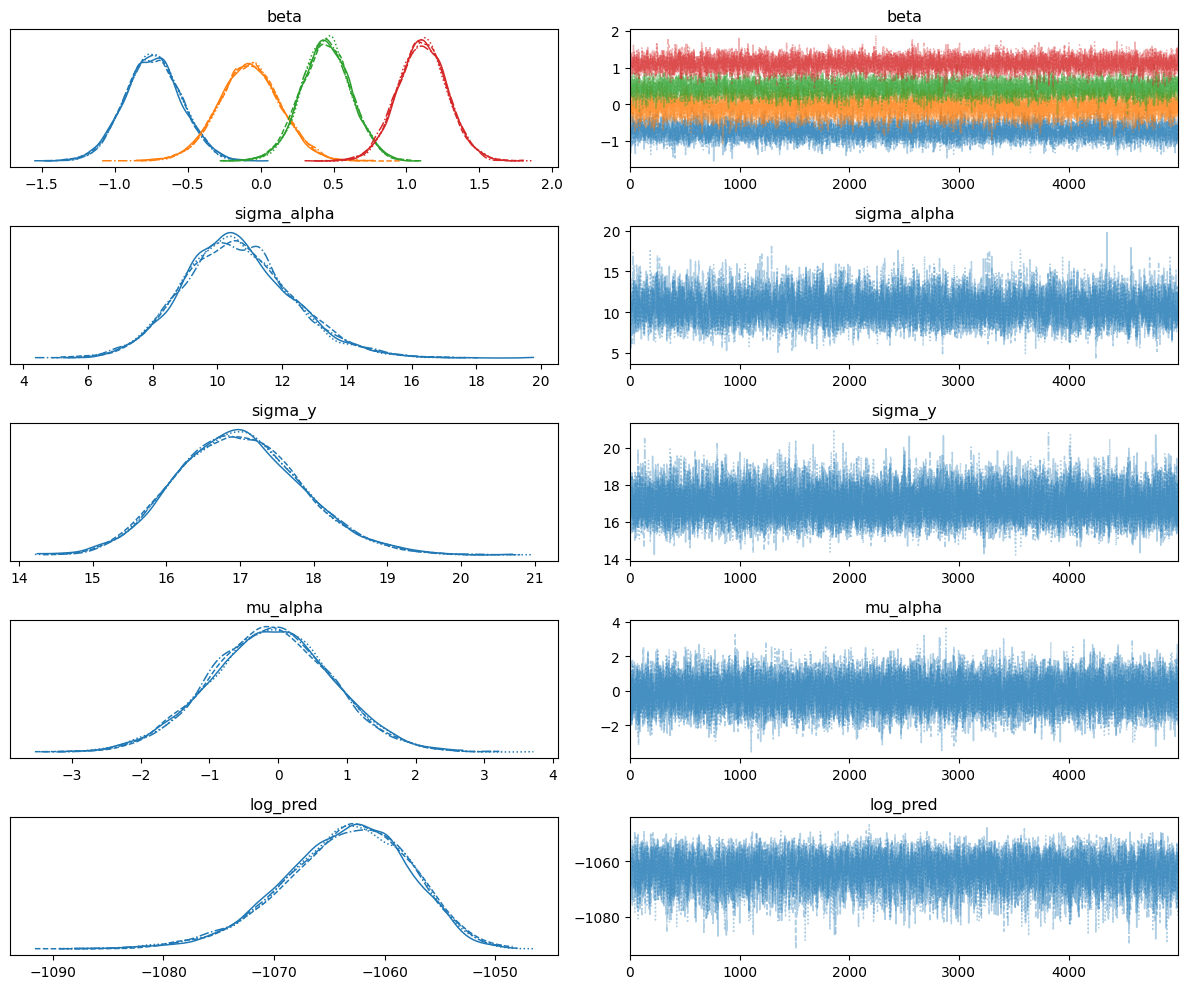

In [ ]:
az.plot_trace(idata, var_names=show_vars)
plt.tight_layout()

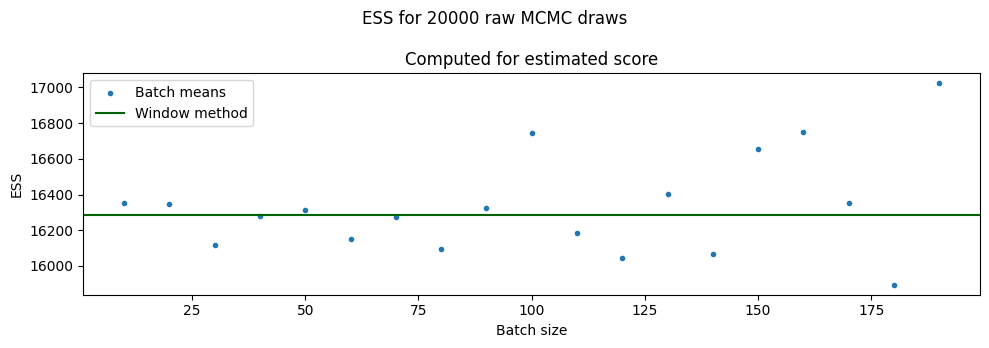

In [ ]:
fig, ax = plot_batch_sizes(idata)
fig.savefig('ess_logs_levels_1A.pdf')

true       beta         = [-0.784 -0.014  0.358  0.916]
true       sigma_alpha  = 9.899000000000001
true       sigma_y      = 18.133
true       mu_alpha     = -0.342
opt        beta         = [-0.611 -0.108  0.371  0.969]
opt        sigma_alpha  = 30.149
opt        sigma_y      = 15.149000000000001
opt        mu_alpha     = -0.031


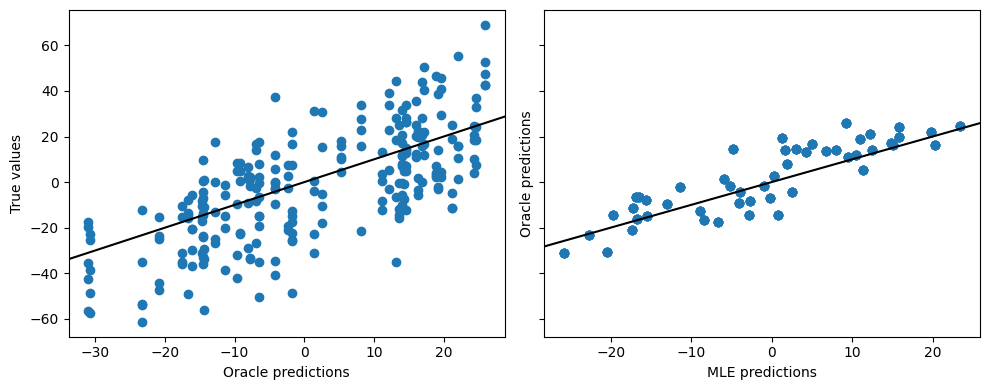

In [ ]:
#@title MLE vs simulated actual observations

def print_param(p, desc):
    for i, k in enumerate(p._fields):
        if k != 'alpha' and k != 'alpha_raw':
            print(f"{desc:10s} {k:12s} = {p[i].round(3)}")
print_param(draw['param'], 'true')
model0 = get_model(y, X, model_p=p)
paramopt = find_initial_params(
    key,
    model0.make_initial_pos,
    lambda x: model0.logjoint_density(x,-1),
    adam_iter=1000,
    adam_lr=.05)
print_param(model0.to_constrained(paramopt), 'opt')

_fig, _axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
_tr, _opt = _axes
yhat = X[group_i,:] @ param0.beta + param0.alpha[group_i]
_tr.scatter(yhat, y)
_tr.axline([0,0], slope=1., color='k')
_tr.set_xlabel('Oracle predictions')
_tr.set_ylabel('True values')
_alpha = paramopt.mu_alpha + paramopt.sigma_alpha * paramopt.alpha_raw
_opt.scatter(X[group_i,:] @ paramopt.beta + _alpha[group_i], yhat)
_opt.axline([0,0], slope=1., color='k')
_opt.set_xlabel('MLE predictions')
_opt.set_ylabel('Oracle predictions')
_fig.tight_layout()

In [ ]:
del idata

In [ ]:
#@title MCMC inference - model B

modelB = get_model(y, X, model_p=3)
resultsB = full_trace_inference(
    model=modelB,
    fold_id=-1,  # full data
    inference_key=infBkey,
    **common_parameters
)
idata = resultsB.arviz()

Running window adaptation



Step size = 0.2592, inv mm norm = 1.6698

Warm-up sampling run
Warmup complete in 12.15 sec
Sampling
Done in 3.23 sec


In [ ]:
az.summary(idata, var_names=show_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.559,0.249,-1.018,-0.082,0.006,0.004,1684.0,3467.0,1.0
beta[1],-0.265,0.286,-0.811,0.261,0.007,0.005,1710.0,3455.0,1.0
beta[2],0.316,0.233,-0.118,0.762,0.005,0.004,1832.0,3693.0,1.0
sigma_alpha,16.243,1.934,12.687,19.865,0.036,0.025,2885.0,6537.0,1.0
sigma_y,16.974,0.835,15.424,18.539,0.009,0.006,8966.0,13689.0,1.0
mu_alpha,-0.161,0.933,-1.937,1.534,0.013,0.009,4932.0,10167.0,1.0
log_pred,-1063.367,5.568,-1073.786,-1053.234,0.072,0.051,6023.0,9421.0,1.0


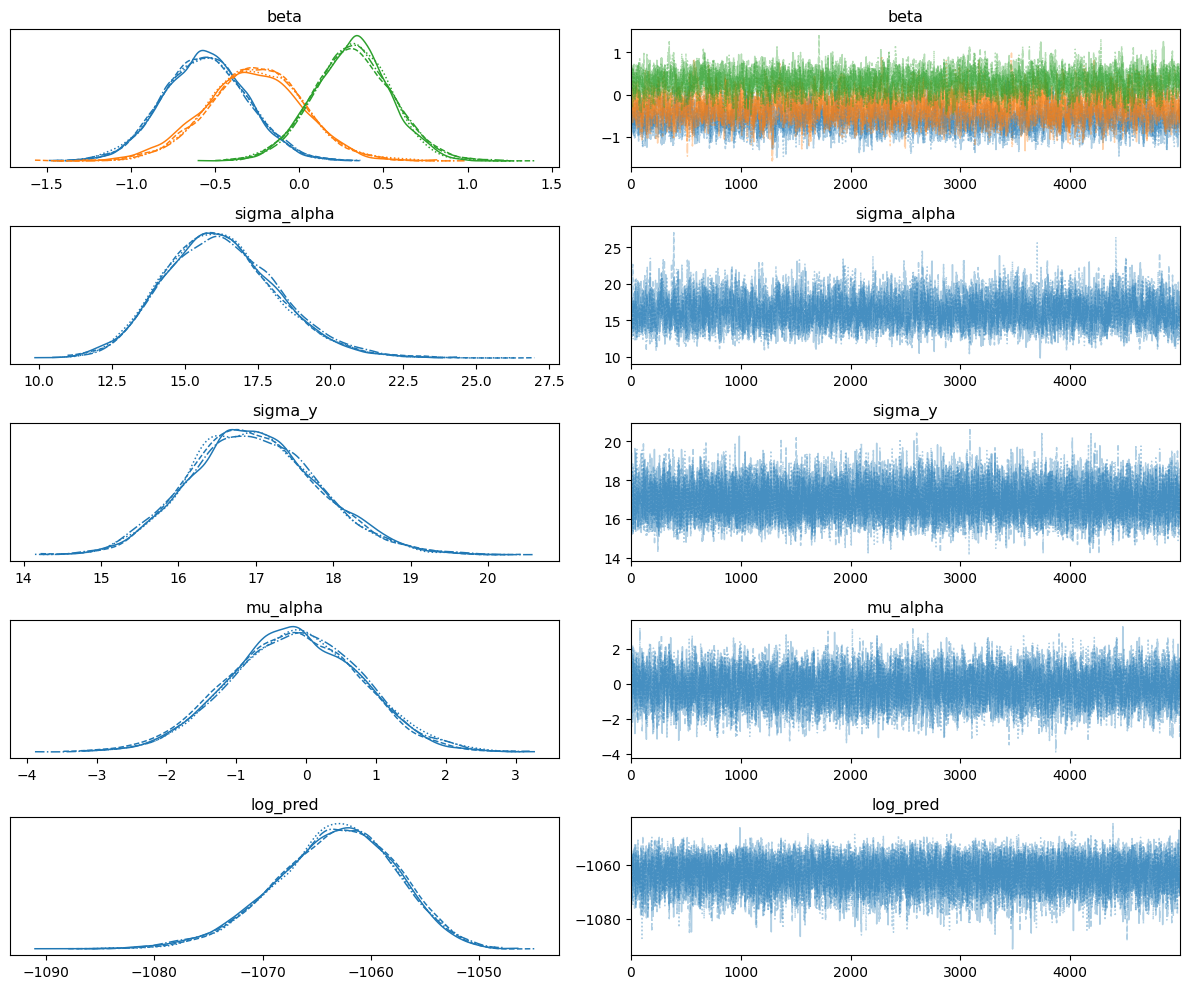

In [ ]:
az.plot_trace(idata, var_names=show_vars)
plt.tight_layout()

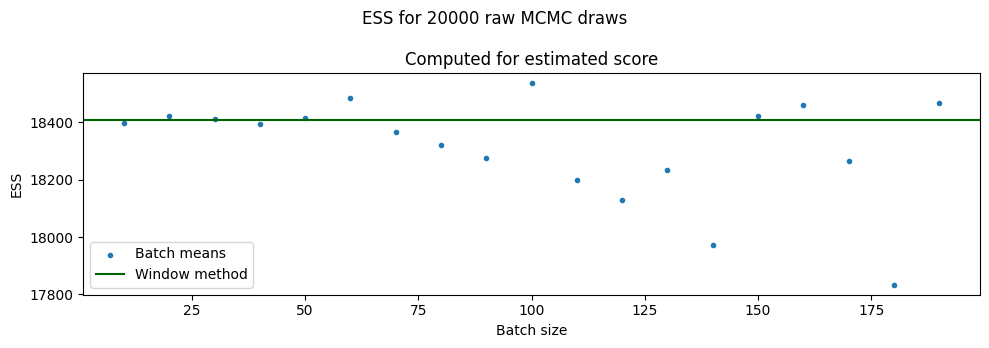

In [ ]:
fig, ax = plot_batch_sizes(idata)
fig.savefig('ess_logs_levels_1B.pdf')

In [ ]:
del idata

In [ ]:
#@title Parallel cross-validation

res = parallel_cv(
    resultsA,
    resultsB,
    inference_key=infCkey,
    num_folds = J,
    batch_size = 50,
    iter = 1000,
    num_chains = 4,
    warmup_iter = 1,
    d = 0.01,
    backend=backend
)

Warmup run
Warmup complete in 4.6 sec
Inference
Inference complete in 5.4 sec
Done


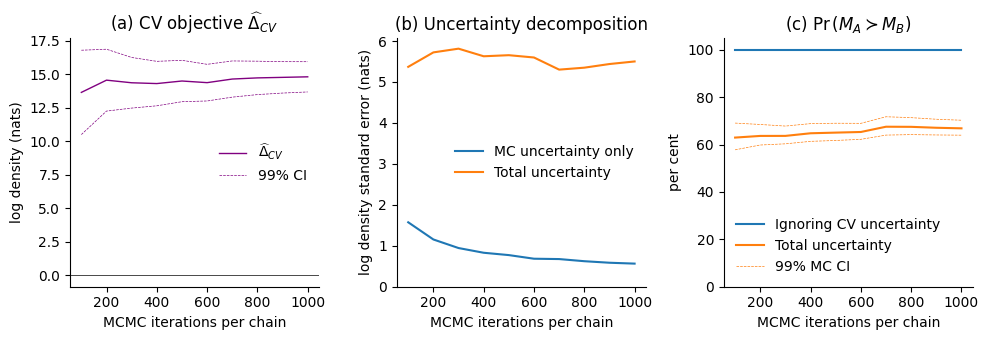

In [ ]:
fig, _ = plot_prog3(res, title=r'Progressive diagnostic estimates - grouped normal example')
fig.savefig('grouped_normal_prog.pdf', bbox_inches='tight')

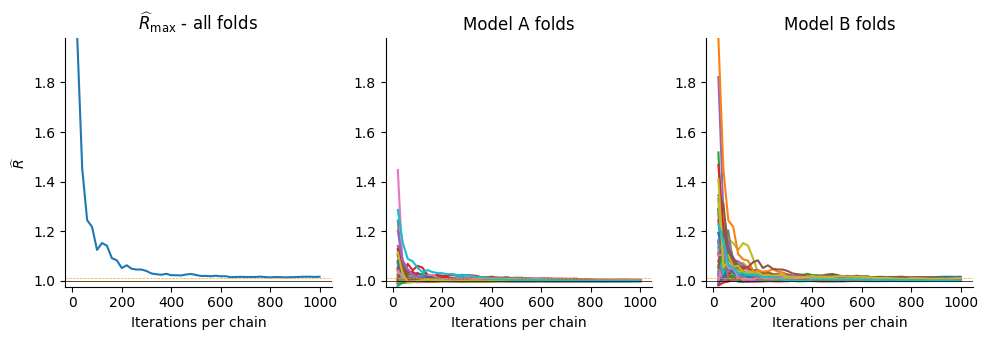

In [ ]:
fig, axes = fold_rhat(res['trace'])
plt.savefig('grouped_normal_rhat.pdf', bbox_inches='tight')

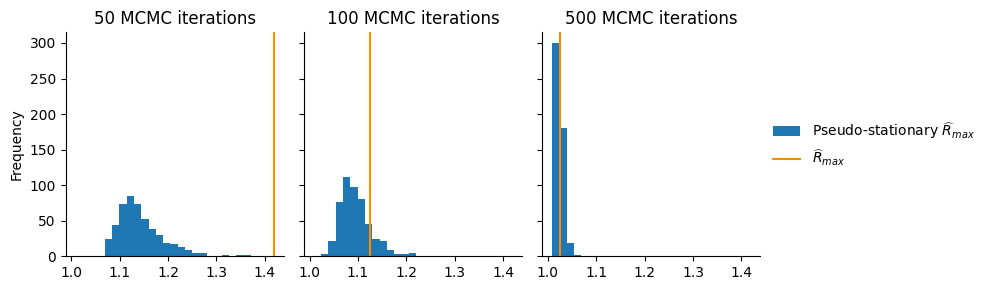

In [ ]:
fig, _ = multi_shuff_max(res['trace'], lengths=[50, 100, 500], breaks=5, ndraws=500)
fig.tight_layout()
fig.savefig('grouped_normal_multi_shuffle.pdf', bbox_inches='tight')

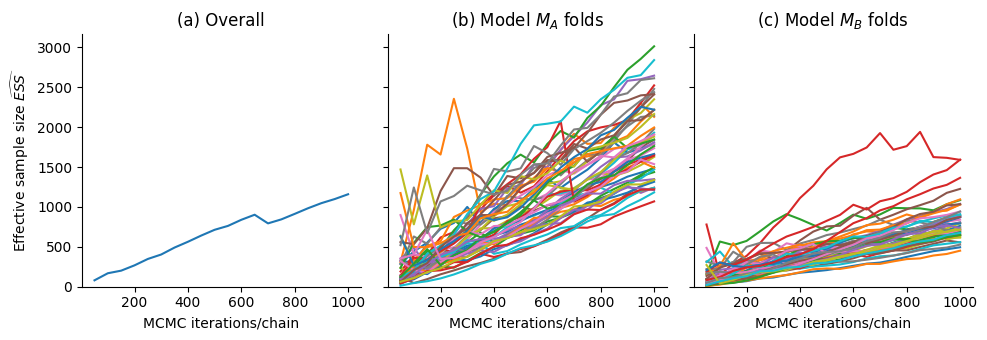

In [ ]:
fig, axes = plot_fold_ess(res['trace'])
fig.savefig('grouped_normal_ess.pdf', bbox_inches='tight')

In [ ]:
with open('cmp1.pkl', 'wb') as f:
    pickle.dump(res, f)

## Rhat benchmark

In [ ]:
# check rhat implementation against arviz
trace = res['trace']
rhats = np.zeros((J,2))
for m in [0, 1]:
    for k in range(J):
        sample = trace[k,:,:,m]
        saz = az.from_dict({'lp': sample})
        rhats[k,m] = az.rhat(saz, method='identity')['lp'].values
assert np.max(rhats - rhat(trace)) < 1e-8

In [ ]:
# emulate a stuck chain
trace_stuck = trace.copy()
trace_stuck[0,0,:,0] = trace_stuck[0,0,0,0]

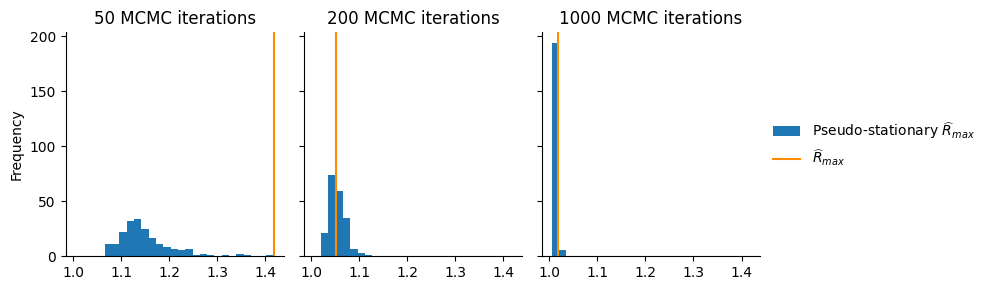

In [ ]:
fig, axes = multi_shuff_max(trace, breaks=5)

In [ ]:
# shift a chain by one unit
trace_shifted = trace.copy()
trace_shifted[13,3,:,1] = trace_shifted[13,3,:,1] + 5

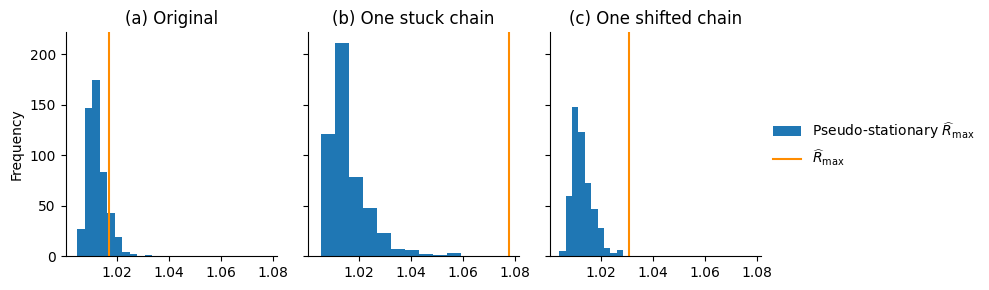

In [ ]:
ndraws=500
breaks=5
figsize=(10, 3)
np.random.seed(seed=123)
traces = [trace, trace_stuck, trace_shifted]
names = ['(a) Original', '(b) One stuck chain', '(c) One shifted chain']
fig, axes = plt.subplots(1, len(traces), figsize=figsize, sharex=True, sharey=True)
for ax, tr, name in zip(axes, traces, names):
    ax.set_title(name)
    shuff_rhmax = np.array([np.max(rhat(shuffle_draws(tr, breaks=breaks)))
        for _ in range(ndraws)])
    ax.hist(shuff_rhmax,
            label=r'Pseudo-stationary $\widehat{R}_{\mathrm{max}}$')
    ax.axvline(np.max(rhat(tr)), color='darkorange',
               label=r'$\widehat{R}_{\mathrm{max}}$')
axes[0].set_ylabel('Frequency')
axes[-1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
unframe_axes(axes)
fig.tight_layout()
fig.savefig('rhatmax_vs_stationary.pdf', bbox_inches='tight')

## Numerical overflow simulation

In [ ]:
#@title Inference

y_out = y.at[25].set(y[25] + 500)

modelA_out = get_model(y_out, X, model_p=4)
resultsA_out = full_trace_inference(
    model=modelA_out,
    fold_id=-1,  # full data
    inference_key=infAkey,
    **common_parameters
)
modelB_out = get_model(y_out, X, model_p=3)
resultsB_out = full_trace_inference(
    model=modelB_out,
    fold_id=-1,  # full data
    inference_key=infBkey,
    **common_parameters
)
res_out = parallel_cv(
    resultsA_out,
    resultsB_out,
    inference_key=infCkey,
    num_folds = J,
    batch_size = 50,
    iter = 1000,
    num_chains = 4,
    warmup_iter = 1,
    d = 0.01,
    backend=backend
)

Running window adaptation



Step size = 0.2430, inv mm norm = 5.2447

Warm-up sampling run
Warmup complete in 8.58 sec
Sampling
Done in 3.23 sec
Running window adaptation



Step size = 0.3794, inv mm norm = 3.7845

Warm-up sampling run
Warmup complete in 13.91 sec
Sampling
Done in 7.46 sec
Warmup run
Warmup complete in 7.7 sec
Inference
Inference complete in 5.2 sec
Done


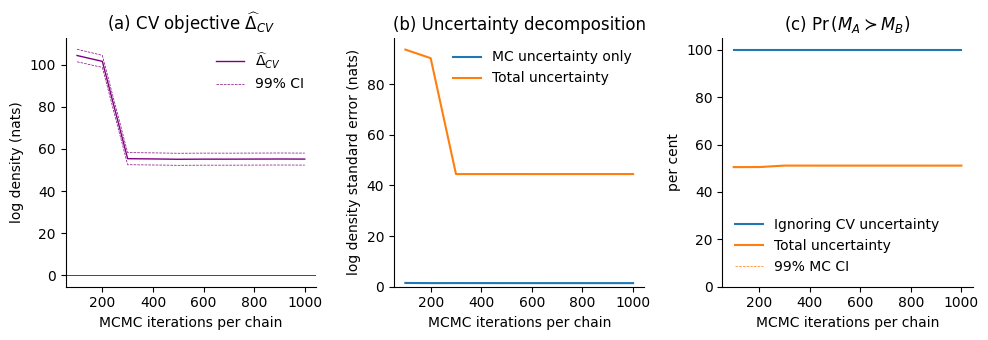

In [ ]:
fig, axes = plot_prog3(res_out)
fig.savefig('grouped_normal_outlier_prog.pdf', bbox_inches='tight')

In [ ]:
!zip grouped_normal.zip *.pdf

updating: ess_logs_levels_1A.pdf (deflated 31%)
updating: ess_logs_levels_1B.pdf (deflated 31%)
updating: grouped_normal_ess.pdf (deflated 23%)
updating: grouped_normal_multi_shuffle.pdf (deflated 39%)
updating: grouped_normal_outlier_prog.pdf (deflated 38%)
updating: grouped_normal_prog.pdf (deflated 37%)
updating: grouped_normal_rhat.pdf (deflated 14%)
updating: rhatmax_vs_stationary.pdf (deflated 40%)
